# Aim

Attempting to implement the Support Vector Kalman method, as described at http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.672.2696&rep=rep1&type=pdf.


In [1]:
from sklearn import svm
from sklearn.model_selection import KFold
import numpy as np
from aberrations import make_vibe_params, make_1D_vibe_data, make_noisy_data, measurement_noise, f_1
from observer import make_kfilter, vibe_fit_freq, get_psd, predict, update, noise_filter
from matplotlib import pyplot as plt
from copy import deepcopy
%matplotlib inline

In [2]:
from aberrations import time_id, f_sampling, f_1, times
W = 10
N = 1
N_vib_app = 1
steps = int(f_sampling * time_id)
times = np.arange(0, time_id, 1 / f_sampling)

In [3]:
# set up state training datam
params = make_vibe_params(N=N_vib_app)
print(params[1:3])
truth = make_1D_vibe_data(vib_params=params)
measurements = make_noisy_data(truth,noise=0.01)

print("Autoregressive coefficients should be: ")
k = params[2]
w0 = 2 * np.pi * params[1]
print(2 *  np.exp(-k * w0 / f_sampling) * np.cos(w0 * np.sqrt(1 - k**2) / f_sampling))
print(-np.exp(-2 * k * w0 / f_sampling))

[array([77.531382]), array([4.24041709e-05])]
Autoregressive coefficients should be: 
[1.76731019]
[-0.99995869]


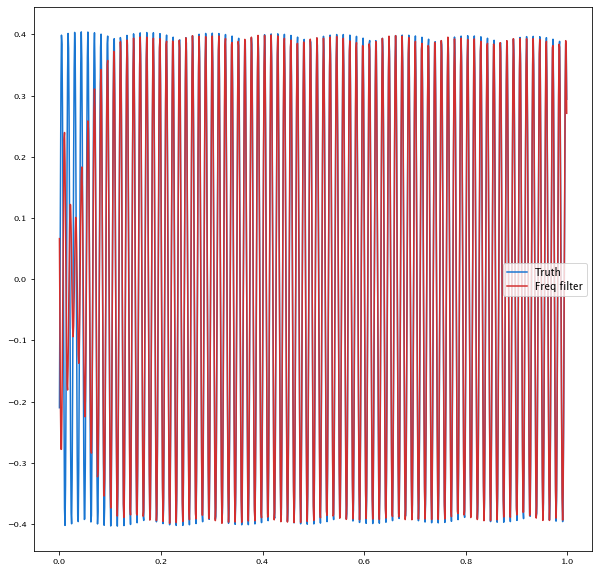

In [4]:
# first, let's run the Kalman filter for half a second normally
state, A, P, Q, H, R = make_kfilter(*vibe_fit_freq(noise_filter(get_psd(measurements)), N=N))
states_freq = np.zeros((steps, state.size))
for k in range(steps):
    state, P = update(H, P, R, state, measurements[k])
    states_freq[k] = state
    state, P = predict(A, P, Q, state)
    
pos_freq = np.array([H.dot(state) for state in states_freq]).flatten()

plt.figure(figsize=(10,10))
plt.plot(times, truth, label='Truth')
plt.plot(times, pos_freq, label='Freq filter')
plt.legend()

In [5]:
def make_state_transition(x_training, y_training):
    x_recentering = (np.min(x_training, axis=0) + np.max(x_training, axis=0))/2
    y_recentering = (np.min(y_training, axis=1) + np.max(y_training, axis=1))/2
    x_training -= np.tile(x_recentering, (W+1, 1))
    y_training -= np.repeat(y_recentering, W+1).reshape(state.size,W+1)
    x_scales = (np.max(x_training, axis=0) - np.min(x_training, axis=0))/2
    y_scales = (np.max(y_training, axis=1) - np.min(y_training, axis=1))/2
    x_training /= np.tile(x_scales, (W+1, 1))
    y_training /= np.repeat(y_scales, W+1).reshape(state.size,W+1)
    
    get_svr = lambda: svm.SVR(kernel='linear',gamma='scale', C=1, epsilon=1e-6)

    A = np.zeros((STATE_SIZE, STATE_SIZE))
    Q = np.zeros((STATE_SIZE, STATE_SIZE))
    svk = [get_svr()] * N
    for i in range(N):
        # help out the SVK by telling it the only state elements that matter
        # we know this is the case because we ran in frequency mode for half a second
        x_training_i = x_training[:,2*i:2*i+2]
        y_training_i = y_training[2*i]
        kfold = KFold(n_splits=W+1)
        svr_cov = get_svr()
        for train, test in kfold.split(x_training_i):
            svr_cov.fit(x_training_i[train], y_training_i[train])
            Q[2*i][2*i] = (svr_cov.predict(x_training_i[test]) - y_training_i[test])**2
        svk[i].fit(x_training_i, y_training[2*i])
        predictions = np.array([svk[i].predict(np.array([[1, 0]]))[0], 
                                svk[i].predict(np.array([[0, 1]]))[0]])
        A[2*i][2*i], A[2*i][2*i+1] = predictions * (y_scales/x_scales)[2*i:2*i+2]
        A[2*i+1][2*i] = 1
    assert not np.allclose(A, np.zeros((STATE_SIZE, STATE_SIZE)))
    return A, Q

In [6]:
# evolve states based on this A.
k = W + 2
state = states_freq[k]
states_svk = np.zeros((steps, state.size))
states_svk[:k] = states_freq[:k]
STATE_SIZE = 2*N
last_refresh = 0
while k < steps:
    # Make the A matrix for a transition from state k to state k + 1. Assumed k > W + 1.
    # threshold is arbitrary
    if np.any([P[2*i][2*i] > Q[2*i][2*i] for i in range(N)]) and k - last_refresh > W and np.sum(np.diag(P)) > 10 * np.sum(np.diag(Q)):
        print(k)
        last_refresh = k
        x_training = states_svk[k-W-2:k-1] # a row is the state at a specific timestep: size (W+1, state.size)
        y_training = states_svk[k-W-1:k].T # a row is a state variable over the W timesteps: size (state.size, W+1)
        save_states = deepcopy(states_svk[k-W-2:k])
        A, Q = make_state_transition(x_training, y_training)
        # if you pass in a deepcopy to make_state_transition it's sad
        # so save a deepcopy, and put it back in later
        states_svk[k-W-2:k] = save_states
    elif k - last_refresh == W:
        print(np.sum(np.diag(P)))
    state, P = update(H, P, R, state, measurements[k])
    states_svk[k] = state
    state, P = predict(A, P, Q, state)
    k += 1
    
pos_svk = np.array([H.dot(state) for state in states_svk]).flatten()

12
7.253389250891212


In [7]:
def extract_regressed_modes(A):
    for i in range(N):
        a1, a2 = A[2*i][2*i], A[2*i][2*i+1]
        print(a1, a2)
        kwo_i = -f_sampling * np.log(-a2)/2
        toarccos = a1/(2*np.sqrt(-a2))
        print(toarccos)
        wo1_k2_i = f_sampling * np.arccos(toarccos)
        wo_i = np.sqrt(kwo_i**2 + wo1_k2_i**2)
        k_i = kwo_i/wo_i
        print(np.round(wo_i, 3), np.round(k_i, 3))

extract_regressed_modes(A)

1.993403184814025 -0.5903474524700842
1.2972130391063716
nan nan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in arccos
  


(-0.40404721499455304, 0.40404721499455304)

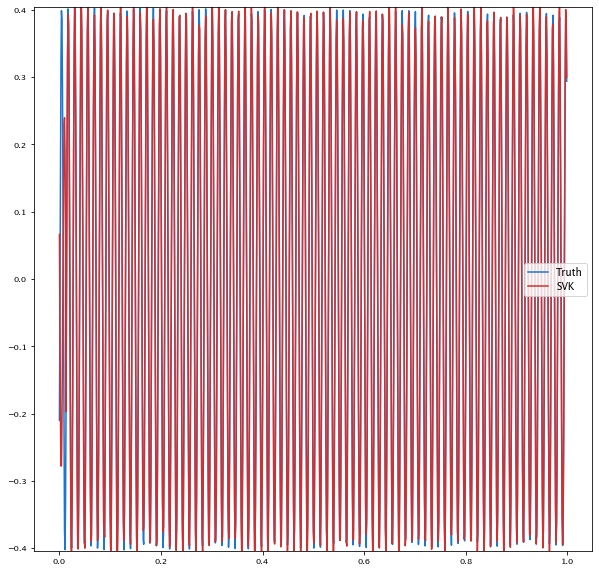

In [8]:
plt.figure(figsize=(10,10))
lim = np.max(np.abs(truth))
plt.plot(times, truth, label='Truth')
plt.plot(times, pos_svk, label='SVK')
plt.legend()
plt.ylim(-lim, lim)

Baseline:  0.008048288905951618


Text(0.5, 1.0, 'Residuals of frequency fit and Support Vector Kalman')

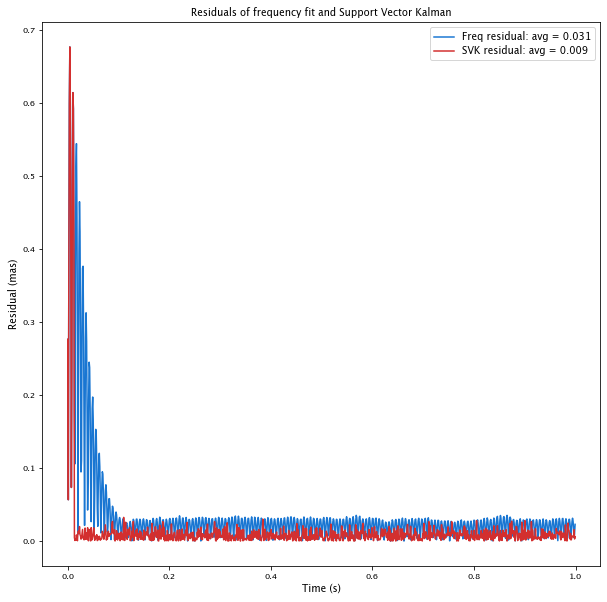

In [9]:
plt.figure(figsize=(10,10))
print("Baseline: ", np.mean(np.abs(measurements - truth)))
res_svk = np.abs(pos_svk - truth)
res_freq = np.abs(pos_freq - truth)
plt.plot(times, res_freq, label='Freq residual: avg = ' 
         + str(np.round(np.mean(res_freq[W+1:]), 3)))
plt.plot(times, res_svk, label='SVK residual: avg = ' 
         + str(np.round(np.mean(res_svk[W+1:]), 3)))
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Residual (mas)")
plt.title("Residuals of frequency fit and Support Vector Kalman")